This data was pulled from the UCI Respository and is a REAL dataset
go to http://archive.ics.uci.edu/ml/datasets/HCC+Survival for more information!

Abstract: Hepatocellular Carcinoma dataset (HCC dataset) 
was collected at a University Hospital in Portugal. 
It contains real clinical data of 165 patients diagnosed with HCC. This project will be 
an interesting look into doing classification with pretty small data, only 165 points.
With almost 50 features (dimensions), this is a hard problem!

It's also a good problem on tackling datasets that are small, as doing maximum likelihood
estimation on small data can give results that might not be flexible for future prediction, while a Bayesian inference will give the whole distribution to play with and do some analysis. The Bayesian contet also lets us put some prior information (even if it isn't so strong), which can give us an edge over maximum likelihood when we don't have a lot of data, especially disease data. 


In [2]:
# First, we read in the file and import packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from sklearn.metrics import confusion_matrix as cmatrix


In [3]:
# Load the HCC data
hcc_data = pd.read_csv('/Users/rabeya/Carcinoma_Classification_data/hcc.csv')

In [4]:
hcc_data

,1.Gen,2.Sym,3.Alc,4.HepB,5.HepB,6.HepB,7.HepC,8.Cir,9.End,10.Smo,...,41.Alk,42.Prot,43.Crea,44.NNod,45.dnod,46.Bil,47.Iro,48.Oxy,49.Fer,Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.7,1,3.5,0.5,?,?,?,1
1,0,?,0,0,0,0,1,1,?,?,...,?,?,?,1,1.8,?,?,?,?,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7,2.1,5,13,0.1,28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.2,?,?,?,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.8,1,9,?,59,15,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,0,1,?,?,?,1,1,0,1,...,109,7.6,0.7,5,3,?,?,?,?,1
161,0,1,0,?,?,?,?,1,0,0,...,280,6.7,0.7,1,2.2,2.3,?,?,?,0
162,1,0,1,0,0,0,0,1,0,1,...,181,7.5,1.46,5,18.6,?,?,?,?,1
163,1,0,1,1,0,1,1,1,1,1,...,170,8.4,0.74,5,18,?,?,?,?,0


According to the UCI website,
this is an heterogeneous dataset, with 23 quantitative variables, 
and 26 qualitative variables. Overall, missing data represents 10.22% 
of the whole dataset and only eight patients have complete information 
in all fields (4.85%). The target variables is the survival at 1 year, 
and was encoded as a binary variable: 0 (dies) and 1 (lives). 
A certain degree of class-imbalance is also present (63 cases labeled as "dies" 
and 102 as "alive").

Our strategy for creating a classification algorithm is to use something different from supervised learning. Supervised learning, of course, deals with creating algorithms to optimize a function, or a mapping/relationship between the input variables (or features), and output labels (1=life, 0=death). Some of thse optimizers include backpropagation (neural networks) and gradient descent (for linear, logistic regression). Random forests and decision trees are also supervised learning, but they don't use gradient optimization. Instead they use stuff called "information-theory" to create their function mappings.

We won't be useing a direct supervised learning algorithm. Instead, after fixing missing values and balancing our dataset, we'll be using an optimizer called Expecgation-Maximization to create a generative model called a Gaussian Mixture model. We can then use this model to calculate the likelihood that a new unseen test-point is in class 1 or 0.

# Part 1: Exploratory Data Analysis (EDA) –– Fixing Missing Values

First we need to fix some missing data; either we replace the missing one with the
mean around the others, or drop it, or some other shit. We'll use Miria santos's method of the HEOM distance to do this. 

In [5]:
hcc_data.columns

Index(['1.Gen', '2.Sym', '3.Alc', '4.HepB', '5.HepB', '6.HepB', '7.HepC',
       '8.Cir', '9.End', '10.Smo', '11.Dia', '12.Obe', '13.Hem', '14.Art',
       '15.CRen', '16.HIV', '17.Non', '18.EVar', '19.Spl', '20.PHyp', '21.Thr',
       '22.LMet', '23.Rad', '24.Agedia', '25.Alcpd', '26.cigpy', '27.Sta',
       '28.Encdeg', '29.Ascdeg', ' 30.IntNorRat', ' 31.Alp', ' 32.Hae',
       ' 33.MCorVol', ' 34.Leu', '35.Plat', '36.Alb', '37.Bil', '38.Ala',
       '39.Aspa', '40.Gam', '41.Alk', '42.Prot', '43.Crea', '44.NNod',
       '45.dnod', '46.Bil', '47.Iro', '48.Oxy', '49.Fer', 'Class'],
      dtype='object')

In [6]:
# in this cell, we have a feature data_type dictionary from the UCI repository 
nominal = 'nominal'
ordinal = 'ordinal'
integer = 'integer'
continuous = 'continuous'
ftypes = {0: nominal,
1: nominal,
2: nominal,
3: nominal,
4: nominal,
5: nominal,
6: nominal,
7: nominal,
8: nominal,
9: nominal,
10: nominal,
11: nominal,
12: nominal,
13: nominal,
14: nominal,
15: nominal,
16: nominal,
17: nominal,
18: nominal,
19: nominal,
20: nominal,
21: nominal,
22: nominal,
23: integer,
24: continuous,
25: continuous,
26: ordinal,
27: ordinal,
28: ordinal,
29: continuous,
30: continuous,
31: continuous,
32: continuous,
33: continuous,
34: continuous,
35: continuous,
36: continuous,
37: continuous,
38: continuous,
39: continuous,
40: continuous,
41: continuous,
42: continuous,
43: integer,
44: continuous,
45: continuous,
46: continuous,
47: continuous,
48: continuous,
49: nominal}

In [7]:
# this cell programs the distance functions we use for fixing the missing values
import math
def HEOM_dist(rowA, rowB, df):
    dist_vec = np.asarray(dist_list(rowA, rowB,df))
    return np.linalg.norm(dist_vec)

def dist_list(vecA, vecB, df):
    L = []
    for j in range(0,len(df.columns)-1):
        # if the attribute is missing from vecA or vecB
        if ((vecA[j] == '?') or (vecB[j] == '?')):
            L.append(1)
        else:
            # if the attribute is there and the feature is discrete
            if ((ftypes[j] == 'nominal') or (ftypes[j] == 'ordinal') or (ftypes[j] == 'integer')):
                if (float(vecA[j]) == float(vecB[j])):
                    L.append(0)
                else:
                    L.append(1)
            # if the attribute is there and the feature is continuous
            elif (ftypes[j] == 'continuous'):
                numerator = abs(float(vecA[j])-float(vecB[j]))
                # denominator is tricky. 
                # first make a copy of df.iloc[:,j]  
                copy = df.iloc[:,j].copy().values
                # then delete '?'
                copy = np.delete(copy, np.where(copy=='?'))
                # finally convert to float
                copy = copy.astype(np.float)
                denominator = max(copy)-min(copy)
                ans = numerator/denominator
                L.append(ans)
    # return the list of distances (based on the coordinate, j)
    return L        

In [8]:
# Now let's fix the missing values!
# for each row-vector v, check if there's missing values
# if there is, we take distancees between v and the set of remaining rows
    # we choose the row-vector w closest, and fill in the missing value
# if v has no missing-values at all, we continue in the loop
import time
from tqdm import tqdm_notebook as tqdm

# initialize the new empty dataframe (0 rows, all columns)
new_df = pd.DataFrame(columns=hcc_data.columns[:-1])

for i in tqdm(hcc_data.index):
    # each row 
    row_i = hcc_data.iloc[i, :][:-1]
    if ('?' in row_i.values):
        # if the row does have any missing values:
        heom_distances = []
        rest = hcc_data.index.delete(i)
        for j in rest:
            # jth-vector is row_j
            row_j = hcc_data.iloc[j,:][:-1]
            # before calculating HEOM, check row_j has complete info in the wanted features
            # if row_j does, calculate HEOM. if not, skip over it.
            # check where the '?' is in row_i, and if row_j has complete data in the same spots
            row_i_missing = np.where(row_i.values == '?')[0]
            if ('?' not in row_j.values[row_i_missing]):
                # if row_j has no missing values in the same spots,
                # then compute the HEOM distance
                D = HEOM_dist(row_i, row_j, hcc_data)
                heom_distances.append((j,D))
            else:
                # otherwise skip this vector and continue with the loop
                continue
                
        # after the distances are computed and stored in a list:       
        # closest vector to row_i according to distance D
        closest_ind = min(heom_distances, key=lambda x: x[1])[0]
        # we need to fill in the missing attributes in row_i from closest_v
        closest_v = hcc_data.iloc[closest_ind, :][:-1].values # this is the row-vector in hcc_data
        # replace the missing attributes from row_i with the corresponding ones from
        # closest_v
        # first we get the indices of the missing_value (the '?' value)
        missing_indexes = np.where(row_i.values == '?')[0]
        # then we get the corresponding values from closest_v
        corresponding_vals = closest_v[missing_indexes.tolist()]
        # finally we replace the values in row_i with the new corresponding values
        row_i[missing_indexes] = corresponding_vals
        # finally update the empty dataframe by adding the row
        new_df = new_df.append(row_i, ignore_index=True)
    else:
        # if there is no missing attribute values in row_i
        # just update the new_df dataframe by adding the row
        new_df = new_df.append(row_i, ignore_index=True)
        
    time.sleep(0.25)
            
   

In [9]:
new_df['Class'] = hcc_data['Class']
new_df.head()

,1.Gen,2.Sym,3.Alc,4.HepB,5.HepB,6.HepB,7.HepC,8.Cir,9.End,10.Smo,...,41.Alk,42.Prot,43.Crea,44.NNod,45.dnod,46.Bil,47.Iro,48.Oxy,49.Fer,Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.7,1,3.5,0.5,52.5,37,856,1
1,0,0,0,0,0,0,1,1,0,0,...,433,6.5,0.87,1,1.8,0.4,52.5,37,856,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7,2.1,5,13,0.1,28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.2,52.5,37,856,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.8,1,9,0.1,59,15,22,1


In [10]:
# next, before we do the matrix, we need to convert everything into float
for col in new_df.columns:
    new_df[col] = pd.to_numeric(new_df[col], errors='coerce')
new_df.head()

,1.Gen,2.Sym,3.Alc,4.HepB,5.HepB,6.HepB,7.HepC,8.Cir,9.End,10.Smo,...,41.Alk,42.Prot,43.Crea,44.NNod,45.dnod,46.Bil,47.Iro,48.Oxy,49.Fer,Class
0,1,0,1,0,0,0,0,1,0,1,...,150.0,7.1,0.70,1,3.5,0.5,52.5,37.0,856.0,1
1,0,0,0,0,0,0,1,1,0,0,...,433.0,6.5,0.87,1,1.8,0.4,52.5,37.0,856.0,1
2,1,0,1,1,0,1,0,1,0,1,...,109.0,7.0,2.10,5,13.0,0.1,28.0,6.0,16.0,1
3,1,1,1,0,0,0,0,1,0,1,...,174.0,8.1,1.11,2,15.7,0.2,52.5,37.0,856.0,0
4,1,1,1,1,0,1,0,1,0,1,...,109.0,6.9,1.80,1,9.0,0.1,59.0,15.0,22.0,1


# Taking A Second Look at the Data

If we successfully balance the labels in our data to be around 50:50 with the imblearn and SMOTE packages as we did above, then we don't really need to worry about the prior ratio of hypothesis in the equation above. Since each label –– 1 (patient lived), and 0 (patient passed) occurs with 50% chance in the training set, it's equally likely to guess each one when we encounter a new point in the test set. Therefore, all we need to focus on is the *likelihood generative model* which we will do with a Gaussian mixture.

First we're going to select the top 10 features (columns) from the main set, since it has a total of 49 features, and honestly, keeping track of 49 features is *a lot* of information. Plus, creating generative models in 49 dimensions gets a bit tricky, and if you have a real-world dataset with even more features (also called *dimensions*, by the way) then it gets even harder to create models. But no one said machine learning would be easy!

(*disclaimer: the "best" features, by the way is determined by something called "mutual information" between the predictor (independent) features and the label (0 or 1) but that is beyond this notebook and I honestly don't understand it enough to confidently explain at all.*)


After we do this let's separate our reduced, 10-dimensional (10 features) dataset into a training and a testing set. 

In [143]:
# before we do anything let's set a global random seed for our ML algorithms
np.random.seed(42)

In [144]:
# let's use scikit SelectK Best features (using mutual information) to determine "the best"
# K "best" parameters/features to select from the 49 parameters we have
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
K = 5
selector = SelectKBest(mutual_info_classif, K)
X = new_df.iloc[:, :-1]
y = new_df.iloc[:, -1]
X_reduced = selector.fit_transform(X,y) 
                                   
features_selected = selector.get_support()

As we can see here, the labels 0 and 1 are balanced. There are now 102 patient-survive records and 102 patient-death records.

In [145]:
y.value_counts()

1    102
0     63
Name: Class, dtype: int64

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_reduced, y, 
                                                   train_size=0.65)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((107, 5), (107,), (58, 5), (58,))

In [147]:
y_train.value_counts()

1    66
0    41
Name: Class, dtype: int64

In [148]:
# these are the best 10 features the computer selected!
feature_names_selected = np.where(features_selected==True)[0].tolist()
all_features = np.asarray(new_df.columns)
all_features[feature_names_selected]

array(['23.Rad', '27.Sta', ' 31.Alp', '36.Alb', '41.Alk'], dtype=object)

As a use case, let's test out logistic regression on our dataset. Since we are using only 130 records for our training set, I don't expect logistic regression to have amazing predictive power on the testing set.

In [149]:
# use logistic regression as a test case model
logreg = LogisticRegression(C=0.5, max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

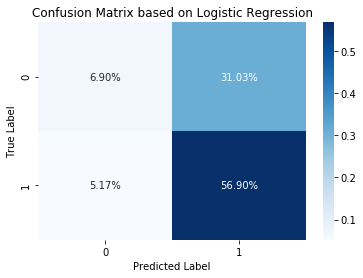

In [150]:
logreg_preds = logreg.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_logreg = confusion_matrix(y_true=np.asarray(y_test), y_pred=logreg_preds)
sns.heatmap(cf_matrix_logreg/np.sum(cf_matrix_logreg), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix based on Logistic Regression')
plt.show()

And....we weren't wrong. While logistic regression kind of nails the false-negative rate at about 11%, its false-positive error rate is 22%, which means that for every 5 new patients with hepatocellular carcinoma, 1 of them would be predicted to survive carcinoma, while their actual chance of survival would be very low. This kind of false-positive error rate should be throughly scrutinized in the context of healthcare patient data related to survival. This is one of the reasons why we'll be looking into generative models to tackle small datasets for the rest of the notebook.

# Part 3: A Generative Classifier


We can do this data analysis a different way. Instead of creating a fully predictive model with logistic regression (or say, a neural network) what if –– we do a non-parametric approach instead?

Let's take a look at the following equation, which states Bayes' Rule of Inference, but for two classification hypotheses we want to test:

$$\frac{P(H_1|Data)}{P(H_2|Data)} = \frac{f(Data|H_1)}{f(Data|H_2)}\frac{P(H_1)}{P(H_2)}$$

This equation basically says, that the odds of Hypothesis 1 being true after seeing the new data point, D, over the odds of Hypothesis 2 being true, is the ratio of how likely D fits hypothesis 1 over hypothesis 2 (symbolized by "f"), times the prior odds we believe that hypothesis 1 is right over hypothesis 2.

The part we call "f" is called the *likelihood* of the data fitting the hypothesis H1 or H2. It's usually difficult to calculate this, and we use the lowercase "f" instead of probability "P" because there are so many data points in our set, we consider the set *continuous* instead, and use "f". You can think of $f(x)$ as a *density* –– it gives us a map of how likely certain data points would be *given* that either hypothesis 1 or 2 is correct.

The difficult part is constructing $f(x)$. This would usually be part of "unsupervised learning", where the computer is traianed to find patterns in data without any labels. You might of heard, for example, K-Means – which clusters data into K different blobs based on the "centroid" of each cluster. 

Gaussian Mixture Modeling (GMM) is a general version of K-Means, and while it can be used for clustering, it has waaaay more power than that. Because GMM is a model, a *probabilistic model*, it basically tells us a whole bunch of info about how dense the data points are, and how probable is certain parts of the data from other parts. and one of the amazing things about GMM is that its a *generative model*, which means you can generate *new* samples of the data from your model pretty easily by just calling the .sample method in Sci-kit Learn. This would be pretty hard to do with K-means. 

In [151]:
# next we are going to separate the transformed dataset into either life (1) or death (0)
# class labels
#the shrunk dataset with only the bst 20 features is called "short_df"
y_train = y_train.reset_index(drop=True)

short_df = pd.DataFrame(X_train, 
                        columns=all_features[feature_names_selected])

short_df['Class'] = y_train
short_df.head()


,23.Rad,27.Sta,31.Alp,36.Alb,41.Alk,Class
0,1.0,2.0,5.7,2.1,110.0,1
1,1.0,3.0,9860.0,3.1,300.0,0
2,1.0,0.0,266.0,4.2,227.0,1
3,0.0,2.0,2.9,2.4,190.0,1
4,0.0,3.0,185203.0,3.6,278.0,0


In [152]:
y_train.value_counts()

1    66
0    41
Name: Class, dtype: int64

In [153]:
short_df_life = short_df[short_df['Class']==1]
short_df_death = short_df[short_df['Class']==0]

short_df_life.shape, short_df_death.shape

((66, 6), (41, 6))

Now, we are going to set up the Gaussian Mixture generative model. First we need to import it, and make an object instance of the class. And for the generative model, we are *not* going to touch the testing data; we'll just be dealing with the training set.

A question you might ask is: how many components do we need to use in the model? It's a great question! And the answer is often: we don't know beforehand. So instead of running 1 generative model, we are going to run 15 of them each model using from 1 componenent to N components. Once we do this, we can use a number called the *Akaike Information Criterion (AIC)* (don't ask me about it!) to determine how many clusters we should use. A good way to do this is called the "elbow method", where we look at the plotted graph of cluster number vs. AIC (it should look like a bent elbow where the bend is at the bottom), and we pick the cluster number closest to the bend.


In [154]:
X_train_life = short_df_life.iloc[:, :-1]
X_train_death = short_df_death.iloc[:, :-1]
X_train_life.shape, X_train_death.shape

((66, 5), (41, 5))

In [191]:
from sklearn.mixture import GaussianMixture as GMM

M = 40
# so M models to train
n_components = np.arange(2, M, 1)

# the covariance type can be "full", "tied", or "diagonal", or "spherical", and I'll 
# detail a picture of what this means below. 
life_models = [GMM(n, covariance_type='tied', tol=1e-4) for n in n_components]
death_models = [GMM(n, covariance_type='tied', tol=1e-4) for n in n_components]

In [194]:
# now we're gonna plot the number of components vs. AIC score to pick the
# "best" density models for the life data and the death data

import time
from tqdm import tqdm_notebook as tqdm

life_bics = []
death_bics = []

print("Fitting {} density models...".format(M))
for model in tqdm(life_models):
    bic = model.fit(X_train_life).bic(X_train_life)
    life_bics.append(bic)
    time.sleep(0.3)
    

print("Fitting {} density models...".format(M))
for model in tqdm(death_models):
    bic = model.fit(X_train_death).bic(X_train_death)
    death_bics.append(bic)
    time.sleep(0.3)

Fitting 40 density models...



Fitting 40 density models...


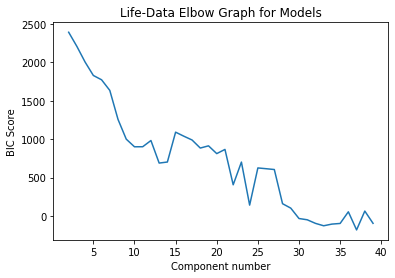

In [197]:
# plot the life aic
plt.xlabel('Component number')
plt.ylabel('BIC Score')
plt.title('Life-Data Elbow Graph for Models')
plt.plot(n_components, life_aics);

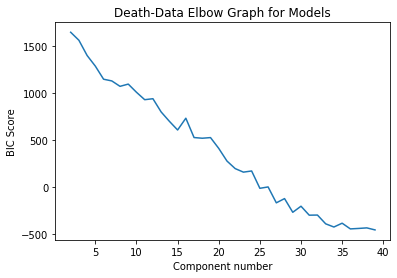

In [198]:
# plot the death aic
plt.xlabel('Component number')
plt.ylabel('BIC Score')
plt.title('Death-Data Elbow Graph for Models')
plt.plot(n_components, death_aics);

From the AIC vs. Component-Number plots for the density estimation models, 
it looks like for now, we'll use 22 components for the life-density model, and 21 components for the death-density models.

Now that we have a rough statistic and idea for which Gaussian mixture models to use, we'll actually train a single optimal model for the life-data and a optimal model for the death-data.

In [205]:
gmm_life = GMM(24, covariance_type='tied',tol=1e-4)
gmm_life.fit(X_train_life)
print(gmm_life.converged_)

gmm_death = GMM(24, covariance_type='tied',tol=1e-4)
gmm_death.fit(X_train_death)
print(gmm_death.converged_)

True
True


Now in order to apply Gaussian Mixture modeling as a predictive tool, ket's go back to the Bayesian inference hypothesis equation above. Because we balanced the class labels in our dataset, the quotient $\frac{P(H_1)}{P(H_2)}$ is 1 because the ratio of life-labels to death-labels is the same. So we only have to worry about the likelihood ratio. 

Dividing numbers in Python can give weird errors, so instead, we'll work with the *logarithm* of the likelihood ratio, written as:

$$log(\frac{P(Data|H_1)}{P(Data|H_2)})$$

which can be written as:

$$delta = log(P(Data|H_1) - log(P(Data|H_2))$$

The numerator we'll call *life_log_prob* and the denominator as *death_log_prob*.

Our key calculation is this: in the quotient of likelihoods, if the quotient is > 1, then the likelihood of the test data point under hypothesis 1 (class label=1) is higher than class label 0, so we classify it as "survival". Otherwise, it's classified as "death". When we take the logarithm of the likelihood ratio, what this classification rule translates to is that we classify the new data point as "survival" if the difference, $delta$ > 0, and "death" if $delta$ < 0.

In [206]:
log_density_life = gmm_life.score_samples(X_test)
log_density_death = gmm_death.score_samples(X_test)

In [207]:
Counter(y)

Counter({1: 102, 0: 63})

In [208]:
log_likelihood_odds = np.subtract(log_density_life, log_density_death)
# now we need to care about the prior odds since the data is not balanced
num_pos = Counter(y)[1]
num_neg = Counter(y)[0]
log_prior_odds = np.repeat(np.log(num_pos/num_neg), len(log_likelihood_odds))

# use bayes formula for inference
log_posterior_odds = np.add(log_likelihood_odds, log_prior_odds)

gmm_predictions = [1 if x>0 else 0 for x in log_posterior_odds]
gmm_predictions = np.asarray(gmm_predictions)

In [209]:
gmm_predictions

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0])

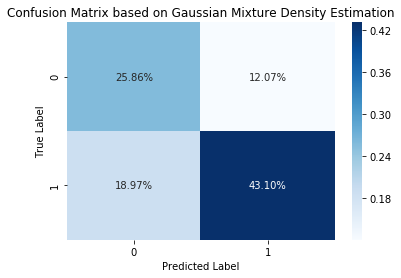

In [210]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



cf_matrix = confusion_matrix(y_true=np.asarray(y_test), y_pred=gmm_predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix based on Gaussian Mixture Density Estimation')
plt.show()

# Kernel Density Estimation
Let's try estimating the likelihood density, instead using the Kernal Density Estimation
algorithm, also from scikit learn! This is similar to the Gaussian Mixture Model, except you apply a Gaussian at *every* point instead of having a fixed cluster of Gaussians. This often gets you a more closer fit to the data distribution, but it also comes at the price of possibly overfitting.

In [169]:
X_train_life.shape, X_train_death.shape

((66, 5), (41, 5))

In [176]:
from sklearn.neighbors import KernelDensity
kde_life = KernelDensity(bandwidth=0.05).fit(X_train_life)
kde_death = KernelDensity(bandwidth=0.05).fit(X_train_death)

log_kde_life = kde_life.score_samples(X_test)
log_kde_death = kde_death.score_samples(X_test)

In [177]:
num_pos = Counter(y)[1]
num_neg = Counter(y)[0]
kde_likelihood_odds = np.subtract(log_kde_life, log_kde_death)
log_prior_odds = np.repeat(np.log(num_pos/num_neg), len(kde_likelihood_odds))

# use bayes formula for inference
kde_posterior_odds = np.add(kde_likelihood_odds, log_prior_odds)

kde_preds = np.asarray([1 if x > 0 else 0 for x in kde_posterior_odds])

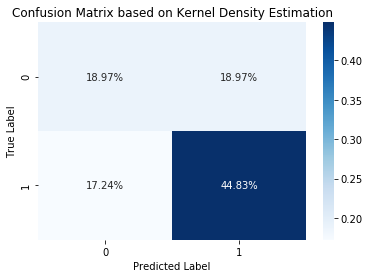

In [178]:
y_test = np.asarray(y_test)


cf_matrix_kde = confusion_matrix(y_true=y_test, y_pred=kde_preds)
sns.heatmap(cf_matrix_kde/np.sum(cf_matrix_kde), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix based on Kernel Density Estimation')
plt.show()

I hope that these results show that density estimation models can be potentially used for classification problems as well, especially when there's a lack of data records. And studies do show that in many fields where data science is used, data-records arne't as common as say, MNIST images or other examples of training-data sets.

$$x: patient record$$
$$y: {treatmentA, treatmentB}$$
$$ y = f(x)$$